# Курс Спортивный анализ данных. Платформа Kaggle

# Практическое задание урока 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:
Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

1.	Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
2.	Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
3.	Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
4.	Выполнить задание 2 для трех моделей.
5.	(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.
6.	(опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [2]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gmean

from pathlib import Path

pd.set_option('display.max_columns', None)

In [3]:
def get_input(dataset_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.
    
    Parametrs
    ---------
    dataset_path: str
        Название файла
        
    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame
    """
    
    data_root = Path('D:/DS_materials/208_kaggle/data_comp/')
    dataset = pd.read_csv(f'{data_root}/{dataset_path}')
    dataset.columns = [col.lower() for col in dataset.columns]
    print(f"{dataset_path} shape: {dataset.shape[0]} rows, {dataset.shape[1]} cols")

    return dataset

In [4]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [5]:
def xgboost_cross_validation(params, fit_params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            **fit_params
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [6]:
def lightgbm_cross_validation(params, fit_params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    #X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            **fit_params
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [7]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()
        
        
    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
            )


    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']

    X["ratio_salary_to_per_family_size"] = X["total_salary"] / X["family_size"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение временных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    """
    # Сделать конкатенацию признаков, рассматривая их как категориальные
    features_1 = ['childrens', 'family_size']
    for feature in features_1:
        X[feature] = X[feature].astype('str')
    
    X["gender_childrens"] = X['gender'] + " | " + X['childrens']
    X["gender_family_status"] = X['gender'] + " | " + X['family_status']    
    X["gender_family_size"] = X['gender'] + " | " + X['family_size'] 
    X["gender_childrens_family_status"] = X['gender_childrens'] + " | " + X['family_status']  
    X["gender_childrens_family_size"] = X['gender_childrens'] + " | " + X['family_size']   
    X["gender_family_status_family_size"] = X['gender_family_status'] + " | " + X['family_size']       
    X["family_status_family_size"] = X['family_status'] + " | " + X['family_size']  
    X["childrens_family_size"] = X['childrens'] + " | " + X['family_size']
    X["childrens_family_status"] = X['childrens'] + " | " + X['family_status']  
    X["childrens_family_status_family_size"] = X['childrens'] + " | " + X['family_status_family_size']  
    """
    
    # Сделать FrequencyEncoder для категориальных признаков
    features_2 = ['gender', 'childrens', 'family_status', 'family_size']   
    for feature in features_2:
        freq_enc = X[feature].value_counts(normalize=True)
        X[feature + "_freq_enc"] = X[feature].map(freq_enc)    
          
    return X

In [8]:
def encode_cat_feats(train, test, categorial):
    for feature in categorial:
        le = LabelEncoder()
        train[feature] = le.fit_transform(train[feature].astype("str").fillna("NA"))
        test[feature] = le.transform(test[feature].astype("str").fillna("NA"))
    return train, test

# Подготовка датасета

In [9]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv shape: 110093 rows, 3 cols
test.csv shape: 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [10]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv shape: 250000 rows, 24 cols


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_salary_to_per_family_size,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,gender_freq_enc,childrens_freq_enc,family_status_freq_enc,family_size_freq_enc
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.428571,0.052832,2.930959,0.236315,0.678568,0.414784,0.329471,0.036237,20.00000,0.085714,1.714286,78750.0,1.577103,31.542056,18.399533,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,0.65858,0.70004,0.097008,0.514472
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.875000,NaN,NaN,0.442295,0.802745,0.622520,0.622520,0.032481,18.86105,0.105433,1.988583,135000.0,1.227714,23.155971,11.644456,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,0.65858,0.70004,0.639384,0.514472


In [11]:
data = data.merge(
    client_profile, how="left", on="application_number"
)

In [12]:
def get_train_test(X: pd.DataFrame) -> pd.DataFrame:
    """
    Формирование обучающей выборки и тестовой выборки
    
    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходными данными.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    train: pandas.core.frame.DataFrame
        Обучающая выборка
        
    test: pandas.core.frame.DataFrame
        Тестовая выборка
        
    target: pd.Series
        Целевая переменная
        
    test_id: pd.Series
        id пользователей для тестовой выборки
    
    categorial: str
        Список категориальных признаков.
    """
    mask = X["target"].isnull()
    features_to_drop = ["application_number", "target"]

    train, test = X.loc[~mask], X.loc[mask]

    target, test_id = train["target"], test["application_number"]
    train = train.drop(features_to_drop, axis=1)
    test = test.drop(features_to_drop, axis=1)

    categorial = train.dtypes[train.dtypes == "object"].index
    numerical = list(set(train.columns) - set(categorial))

    train = train.replace(np.inf, np.nan)
    train = train.replace(-np.inf, np.nan)
  
    return train, test, target, test_id, categorial

In [13]:
train, test, target, test_id, categorial = get_train_test(data)

In [14]:
CAT_FEATS = categorial.tolist()
print(f"Categorical Features Count: {len(CAT_FEATS)}")
CAT_FEATS

Categorical Features Count: 4


['name_contract_type', 'gender', 'education_level', 'family_status']

In [15]:
train_encode, test_encode = encode_cat_feats(train, test, categorial)

## Задание 1
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [16]:
seed = 42
np.random.seed(seed)

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

### LightGBM model

In [17]:
lgbm_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "objective": "binary",
    "boosting_type": "gbdt",    
    "max_bin": 20,
    "max_depth": 6,
    "random_seed": seed
}
lgbm_fit_params = {
    "eval_metric": "auc",
    "early_stopping_rounds": 50,
    "verbose": 50
}


lgbm_estimators, lgbm_oof_preds = lightgbm_cross_validation(
    params=lgbm_params, fit_params=lgbm_fit_params, X=train_encode, y=target, cv=cv
)

Sun Oct 31 19:46:53 2021, Cross-Validation, 110093 rows, 57 cols
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.720913	training's binary_logloss: 0.262911	valid_1's auc: 0.702475	valid_1's binary_logloss: 0.274015
[100]	training's auc: 0.729627	training's binary_logloss: 0.256255	valid_1's auc: 0.707372	valid_1's binary_logloss: 0.268708
[150]	training's auc: 0.736012	training's binary_logloss: 0.252428	valid_1's auc: 0.709847	valid_1's binary_logloss: 0.266229
[200]	training's auc: 0.741844	training's binary_logloss: 0.2499	valid_1's auc: 0.712157	valid_1's binary_logloss: 0.264895
[250]	training's auc: 0.747422	training's binary_logloss: 0.247822	valid_1's auc: 0.71508	valid_1's binary_logloss: 0.264005
[300]	training's auc: 0.752743	training's binary_logloss: 0.246025	valid_1's auc: 0.716881	valid_1's binary_logloss: 0.263393
[350]	training's auc: 0.757574	training's binary_logloss: 0.244463	valid_1's auc: 0.718231	valid_1's binary_logloss: 0.263

In [18]:
# Score by each fold: [0.71987, 0.72287, 0.73048, 0.721, 0.72514]

lgbm_oof_score = roc_auc_score(
    target, lgbm_oof_preds
)
print(f"OOF-score = {round(lgbm_oof_score, 5)}")
# OOF-score = 0.72286

OOF-score = 0.72286


### XGBoost model

In [19]:
xgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "max_bin": 20,
    "max_depth": 6,
    "nthread": 6,
    "seed": seed
}
xgb_fit_params = {
    "early_stopping_rounds": 50,
    "verbose":50,    
    "eval_metric": "auc"    
}

xgb_estimators, xgb_oof_preds = xgboost_cross_validation(
    params=xgb_params, fit_params=xgb_fit_params, X=train_encode, y=target, cv=cv
)

Sun Oct 31 19:48:03 2021, Cross-Validation, 110093 rows, 57 cols


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70718	validation_1-auc:0.69074
[50]	validation_0-auc:0.72979	validation_1-auc:0.70027
[100]	validation_0-auc:0.73670	validation_1-auc:0.70180
[150]	validation_0-auc:0.74275	validation_1-auc:0.70298
[200]	validation_0-auc:0.75051	validation_1-auc:0.70576
[250]	validation_0-auc:0.75551	validation_1-auc:0.70859
[300]	validation_0-auc:0.76198	validation_1-auc:0.71080
[350]	validation_0-auc:0.76922	validation_1-auc:0.71343
[400]	validation_0-auc:0.77623	validation_1-auc:0.71428
[450]	validation_0-auc:0.78350	validation_1-auc:0.71605
[500]	validation_0-auc:0.79011	validation_1-auc:0.71851
[550]	validation_0-auc:0.79577	validation_1-auc:0.72015
[600]	validation_0-auc:0.80038	validation_1-auc:0.72054
[650]	validation_0-auc:0.80399	validation_1-auc:0.72105
[700]	validation_0-auc:0.80760	validation_1-auc:0.72157
[750]	validation_0-auc:0.81029	validation_1-auc:0.72216
[800]	validation_0-auc:0.81349	validation_1-auc:0.72187
[831]	validation_0-auc:0.81494	validation_1-auc:0.7

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70677	validation_1-auc:0.69640
[50]	validation_0-auc:0.72887	validation_1-auc:0.70707
[100]	validation_0-auc:0.73381	validation_1-auc:0.70756
[150]	validation_0-auc:0.73873	validation_1-auc:0.71065
[200]	validation_0-auc:0.74658	validation_1-auc:0.71351
[250]	validation_0-auc:0.75191	validation_1-auc:0.71552
[300]	validation_0-auc:0.75979	validation_1-auc:0.71887
[350]	validation_0-auc:0.76782	validation_1-auc:0.72167
[400]	validation_0-auc:0.77524	validation_1-auc:0.72257
[450]	validation_0-auc:0.78238	validation_1-auc:0.72435
[500]	validation_0-auc:0.78765	validation_1-auc:0.72590
[550]	validation_0-auc:0.79231	validation_1-auc:0.72692
[600]	validation_0-auc:0.79712	validation_1-auc:0.72740
[637]	validation_0-auc:0.80005	validation_1-auc:0.72735
Fold 2, Valid score = 0.72763


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70523	validation_1-auc:0.69588
[50]	validation_0-auc:0.72659	validation_1-auc:0.70957
[100]	validation_0-auc:0.73378	validation_1-auc:0.71105
[150]	validation_0-auc:0.74013	validation_1-auc:0.71264
[200]	validation_0-auc:0.74623	validation_1-auc:0.71692
[250]	validation_0-auc:0.75292	validation_1-auc:0.72013
[300]	validation_0-auc:0.76050	validation_1-auc:0.72339
[350]	validation_0-auc:0.76735	validation_1-auc:0.72621
[400]	validation_0-auc:0.77428	validation_1-auc:0.72883
[450]	validation_0-auc:0.78101	validation_1-auc:0.73109
[500]	validation_0-auc:0.78714	validation_1-auc:0.73280
[550]	validation_0-auc:0.79260	validation_1-auc:0.73347
[600]	validation_0-auc:0.79733	validation_1-auc:0.73467
[650]	validation_0-auc:0.80120	validation_1-auc:0.73547
[700]	validation_0-auc:0.80431	validation_1-auc:0.73579
[738]	validation_0-auc:0.80649	validation_1-auc:0.73612
Fold 3, Valid score = 0.73625


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70948	validation_1-auc:0.68769
[50]	validation_0-auc:0.72882	validation_1-auc:0.70053
[100]	validation_0-auc:0.73365	validation_1-auc:0.70339
[150]	validation_0-auc:0.74125	validation_1-auc:0.70610
[200]	validation_0-auc:0.74932	validation_1-auc:0.70738
[250]	validation_0-auc:0.75545	validation_1-auc:0.70898
[300]	validation_0-auc:0.76028	validation_1-auc:0.71193
[350]	validation_0-auc:0.76748	validation_1-auc:0.71460
[400]	validation_0-auc:0.77399	validation_1-auc:0.71734
[450]	validation_0-auc:0.78144	validation_1-auc:0.71884
[500]	validation_0-auc:0.78752	validation_1-auc:0.71982
[550]	validation_0-auc:0.79309	validation_1-auc:0.72135
[600]	validation_0-auc:0.79779	validation_1-auc:0.72213
[650]	validation_0-auc:0.80115	validation_1-auc:0.72293
[700]	validation_0-auc:0.80414	validation_1-auc:0.72341
[750]	validation_0-auc:0.80684	validation_1-auc:0.72375
[800]	validation_0-auc:0.80906	validation_1-auc:0.72414
[850]	validation_0-auc:0.81148	validation_1-auc:0.7

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70842	validation_1-auc:0.69386
[50]	validation_0-auc:0.72713	validation_1-auc:0.70053
[100]	validation_0-auc:0.73517	validation_1-auc:0.70244
[150]	validation_0-auc:0.73988	validation_1-auc:0.70425
[200]	validation_0-auc:0.74681	validation_1-auc:0.70972
[250]	validation_0-auc:0.75297	validation_1-auc:0.71228
[300]	validation_0-auc:0.75939	validation_1-auc:0.71458
[350]	validation_0-auc:0.76757	validation_1-auc:0.71674
[400]	validation_0-auc:0.77517	validation_1-auc:0.71874
[450]	validation_0-auc:0.78240	validation_1-auc:0.72130
[500]	validation_0-auc:0.78817	validation_1-auc:0.72325
[550]	validation_0-auc:0.79380	validation_1-auc:0.72477
[600]	validation_0-auc:0.79852	validation_1-auc:0.72533
[650]	validation_0-auc:0.80200	validation_1-auc:0.72573
[700]	validation_0-auc:0.80489	validation_1-auc:0.72655
[750]	validation_0-auc:0.80787	validation_1-auc:0.72698
[789]	validation_0-auc:0.81006	validation_1-auc:0.72693
Fold 5, Valid score = 0.72702
Score by each fold: [

In [20]:
# Score by each fold: [0.72219, 0.72763, 0.73625, 0.7254, 0.72702]

xgb_oof_score = roc_auc_score(
    target, xgb_oof_preds
)
print(f"OOF-score = {round(xgb_oof_score, 5)}")
# OOF-score = 0.72668

OOF-score = 0.72668


### Prediction Correlation for LightGBM & XGBoost

In [21]:
scores_2 = pd.DataFrame({
    "lgbm": lgbm_oof_preds,
    "xgb": xgb_oof_preds,
})

corr_2 = scores_2.corr()
mask = np.zeros_like(corr_2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-21-2808fd249174>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_2, dtype=np.bool)


<AxesSubplot:>

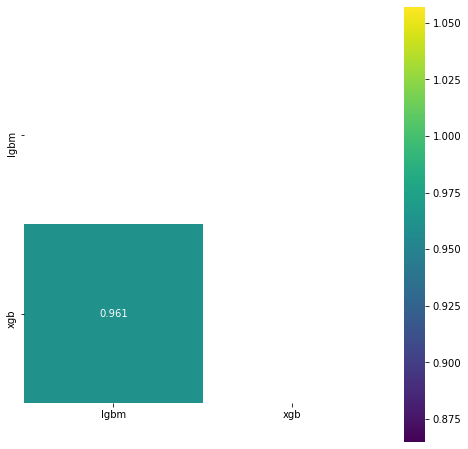

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_2, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

### Test Correlation for LightGBM & XGBoost

In [23]:
def predict_by_estimators(test, estimators, test_id=test_id):
    y_pred = np.zeros(test.shape[0])

    for estimator in estimators:
        y_pred += estimator.predict_proba(test)[:, 1]
        
    y_pred = pd.DataFrame({
        "APPLICATION_NUMBER": test_id,
        "TARGET": y_pred / len(estimators)
    })
    return y_pred

In [41]:
xgb_y_pred = predict_by_estimators(test_encode, xgb_estimators)
lgbm_y_pred = predict_by_estimators(test_encode, lgbm_estimators)

In [42]:
scores_test_2 = pd.DataFrame({
    "lgbm": lgbm_y_pred["TARGET"],
    "xgb": xgb_y_pred["TARGET"],
})

corr_test_2 = scores_test_2.corr()
mask = np.zeros_like(corr_test_2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-42-b9b1694668bb>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_test_2, dtype=np.bool)


<AxesSubplot:>

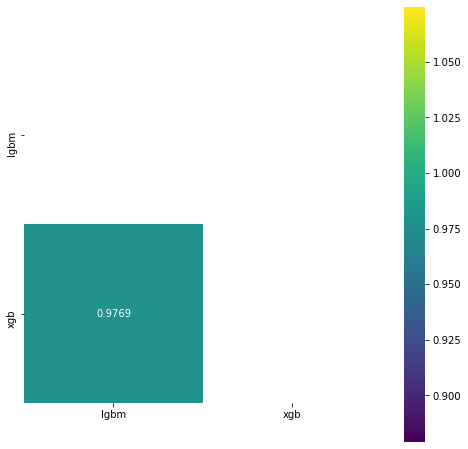

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_test_2, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

**Вывод**
* Наблюдается высокая коррелляция между рассматриваемыми моделями LightGBM и XGBoost, что свидетельствует о схожей предсказательной силе.

## Задание 2
Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [27]:
scores_amean = scores_2.mean(axis=1)
auc_amean = roc_auc_score(target, scores_amean)
print(f"AMean Score = {round(auc_amean, 5)}")

scores_gmean = gmean(scores_2, axis=1)
auc_gmean = roc_auc_score(target, scores_gmean)
print(f"GMean Score = {round(auc_gmean, 5)}")

scores_rankdata = scores_2.rank().mean(axis=1)
auc_rankdata = roc_auc_score(target, scores_rankdata)
print(f"Rankdata Score = {round(auc_rankdata, 5)}")

scores_gmean_rankdata = gmean(scores_2.rank(), axis=1)
auc_gmean_rankdata = roc_auc_score(target, scores_gmean_rankdata)
print(f"GMean Rankdata Score = {round(auc_gmean_rankdata, 5)}")

AMean Score = 0.72584
GMean Score = 0.72576
Rankdata Score = 0.72584
GMean Rankdata Score = 0.72582


**Вывод**
* Качество на одиночных моделях составляет: LightGBM - 0.72286, XGBoost - 0.72668
* Качество усредненных прогнозов по двум моделям состаявляет AMean - 0.72584, GMean - 0.72576, Rankdata - 0.72584, GMean Rankdata - 0.72582 .
* Качество усредненных прогнозов по двум моделям близко друг к другу. 
* Качество на одиночной модели XGBoost выше, чем качество усредненных прогнозов по двум моделям и качество на одиночной модели LightGBM.

## Задание 3
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

### CatBoost model

In [28]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": seed
}

cb_estimators, cb_oof_preds = catboost_cross_validation(
    params=cb_params, X=train_encode, y=target, cv=cv, categorical=None
)

Sun Oct 31 20:19:27 2021, Cross-Validation, 110093 rows, 57 cols
0:	test: 0.6676419	test1: 0.6565851	best: 0.6565851 (0)	total: 203ms	remaining: 6m 46s
50:	test: 0.7072350	test1: 0.6990368	best: 0.6990368 (50)	total: 2.88s	remaining: 1m 50s
100:	test: 0.7109242	test1: 0.7032906	best: 0.7032906 (100)	total: 5.58s	remaining: 1m 44s
150:	test: 0.7137146	test1: 0.7061418	best: 0.7061418 (150)	total: 8.32s	remaining: 1m 41s
200:	test: 0.7171668	test1: 0.7086127	best: 0.7086127 (200)	total: 11.5s	remaining: 1m 43s
250:	test: 0.7195405	test1: 0.7108951	best: 0.7109810 (249)	total: 14.3s	remaining: 1m 39s
300:	test: 0.7223988	test1: 0.7131276	best: 0.7131610 (298)	total: 17.1s	remaining: 1m 36s
350:	test: 0.7249552	test1: 0.7140680	best: 0.7140680 (350)	total: 19.9s	remaining: 1m 33s
400:	test: 0.7276370	test1: 0.7153257	best: 0.7153257 (400)	total: 22.5s	remaining: 1m 29s
450:	test: 0.7297042	test1: 0.7165595	best: 0.7166820 (433)	total: 25.2s	remaining: 1m 26s
500:	test: 0.7315794	test1: 0.7

200:	test: 0.7157954	test1: 0.7111899	best: 0.7113442 (198)	total: 11.6s	remaining: 1m 44s
250:	test: 0.7190971	test1: 0.7135174	best: 0.7135174 (250)	total: 15.2s	remaining: 1m 45s
300:	test: 0.7218266	test1: 0.7159561	best: 0.7161072 (299)	total: 18.3s	remaining: 1m 43s
350:	test: 0.7240180	test1: 0.7174955	best: 0.7174955 (350)	total: 21.5s	remaining: 1m 40s
400:	test: 0.7265128	test1: 0.7187277	best: 0.7187281 (398)	total: 24.6s	remaining: 1m 37s
450:	test: 0.7289258	test1: 0.7196873	best: 0.7196873 (450)	total: 27.7s	remaining: 1m 35s
500:	test: 0.7309218	test1: 0.7204517	best: 0.7204517 (500)	total: 30.7s	remaining: 1m 31s
550:	test: 0.7325789	test1: 0.7213493	best: 0.7213755 (546)	total: 33.6s	remaining: 1m 28s
600:	test: 0.7343768	test1: 0.7221950	best: 0.7221950 (600)	total: 36.6s	remaining: 1m 25s
650:	test: 0.7357887	test1: 0.7229075	best: 0.7229075 (650)	total: 39.6s	remaining: 1m 22s
700:	test: 0.7371983	test1: 0.7235591	best: 0.7235591 (700)	total: 42.7s	remaining: 1m 19s

In [29]:
# Score by each fold: [0.72311, 0.72479, 0.72903, 0.72157, 0.72631]

cb_oof_score = roc_auc_score(
    target, cb_oof_preds
)
print(f"OOF-score = {round(cb_oof_score, 5)}")
# OOF-score = 0.724

OOF-score = 0.724


### Prediction Correlation

In [46]:
scores_3 = pd.DataFrame({
    "lgbm": lgbm_oof_preds,
    "xgb": xgb_oof_preds,
    "cb": cb_oof_preds,
})

corr_3 = scores_3.corr()
mask = np.zeros_like(corr_3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-46-78669812e1f9>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_3, dtype=np.bool)


<AxesSubplot:>

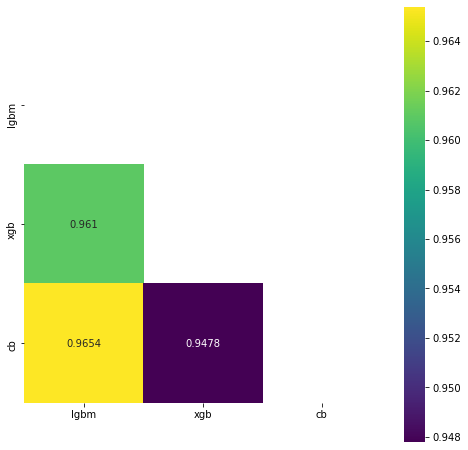

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_3, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

### Test Correlation

In [44]:
cb_y_pred  = predict_by_estimators(test_encode, cb_estimators)

In [45]:
scores_test_3 = pd.DataFrame({
    "lgbm": lgbm_y_pred["TARGET"],
    "xgb": xgb_y_pred["TARGET"],
    "cb": cb_y_pred["TARGET"],
})

corr_test_3 = scores_test_3.corr()
mask = np.zeros_like(corr_test_3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-45-8ba3ae7b8914>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_test_3, dtype=np.bool)


<AxesSubplot:>

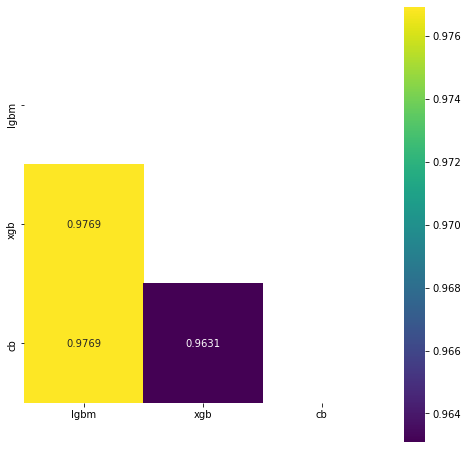

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_test_3, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

**Вывод**
* Наблюдается высокая корреляция между рассматриваемыми тремя моделями, что свидетельствует о схожей предсказательной силе.
* Корреляция между моделями на тестовой выборке выше, чем на обучающей выборке

### Catboost с категориальными признаками

In [35]:
%%time

# Кросс-валидация

cb_cat_estimators, cb_cat_oof_preds = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv, categorical=CAT_FEATS
)

Sun Oct 31 20:24:22 2021, Cross-Validation, 110093 rows, 57 cols
0:	test: 0.6750450	test1: 0.6725448	best: 0.6725448 (0)	total: 222ms	remaining: 7m 22s
50:	test: 0.7075599	test1: 0.7019942	best: 0.7019942 (50)	total: 9.76s	remaining: 6m 12s
100:	test: 0.7098210	test1: 0.7039208	best: 0.7041863 (83)	total: 19.5s	remaining: 6m 7s
150:	test: 0.7123233	test1: 0.7059732	best: 0.7059778 (145)	total: 29.2s	remaining: 5m 57s
200:	test: 0.7166612	test1: 0.7099389	best: 0.7099966 (199)	total: 38.7s	remaining: 5m 46s
250:	test: 0.7199851	test1: 0.7118843	best: 0.7119478 (247)	total: 48.9s	remaining: 5m 40s
300:	test: 0.7232534	test1: 0.7142375	best: 0.7142375 (300)	total: 58.7s	remaining: 5m 31s
350:	test: 0.7255715	test1: 0.7149236	best: 0.7149624 (348)	total: 1m 8s	remaining: 5m 20s
400:	test: 0.7279732	test1: 0.7170524	best: 0.7170524 (400)	total: 1m 17s	remaining: 5m 8s
450:	test: 0.7302781	test1: 0.7183522	best: 0.7184663 (445)	total: 1m 26s	remaining: 4m 57s
500:	test: 0.7323640	test1: 0.71

50:	test: 0.7064700	test1: 0.7010255	best: 0.7010255 (50)	total: 13.7s	remaining: 8m 41s
100:	test: 0.7089789	test1: 0.7044224	best: 0.7045582 (99)	total: 27.3s	remaining: 8m 33s
150:	test: 0.7109562	test1: 0.7061083	best: 0.7061083 (150)	total: 40.9s	remaining: 8m 20s
200:	test: 0.7150975	test1: 0.7090696	best: 0.7091310 (198)	total: 54.4s	remaining: 8m 6s
250:	test: 0.7183822	test1: 0.7120193	best: 0.7120624 (247)	total: 1m 8s	remaining: 7m 55s
300:	test: 0.7214079	test1: 0.7143127	best: 0.7143231 (299)	total: 1m 21s	remaining: 7m 42s
350:	test: 0.7239763	test1: 0.7160389	best: 0.7160389 (350)	total: 1m 35s	remaining: 7m 29s
400:	test: 0.7265081	test1: 0.7180159	best: 0.7180159 (400)	total: 1m 49s	remaining: 7m 17s
450:	test: 0.7289416	test1: 0.7194632	best: 0.7194826 (449)	total: 2m 2s	remaining: 7m 2s
500:	test: 0.7310990	test1: 0.7203631	best: 0.7203709 (498)	total: 2m 12s	remaining: 6m 36s
550:	test: 0.7326683	test1: 0.7206529	best: 0.7206743 (549)	total: 2m 22s	remaining: 6m 13s

In [36]:
cb_cat_oof_score = roc_auc_score(
    target, cb_cat_oof_preds
)
print(f"OOF-score = {round(cb_cat_oof_score, 5)}")
# OOF-score = 0.72417

OOF-score = 0.72417


### Prediction Correlation

In [37]:
scores_4 = pd.DataFrame({
    "lgbm": lgbm_oof_preds,
    "xgb": xgb_oof_preds,
    "cb": cb_oof_preds,
    "cb_cat": cb_cat_oof_preds,
})

corr_4 = scores_4.corr()
mask = np.zeros_like(corr_4, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-37-623c950fa4e3>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_4, dtype=np.bool)


<AxesSubplot:>

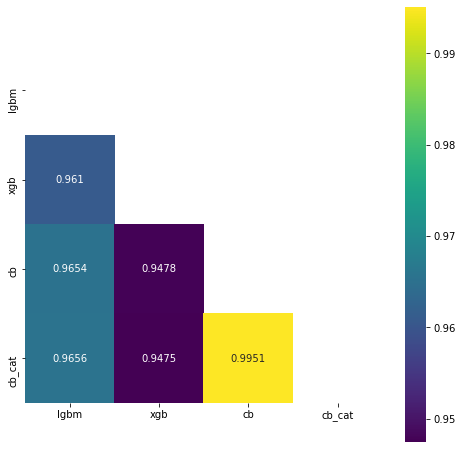

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_4, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [39]:
# Прогнозные значения Catboost с категриальными признаками
cb_cat_y_pred  = predict_by_estimators(test_encode, cb_cat_estimators)

### Test Correlation

In [49]:
scores_test_4 = pd.DataFrame({
    "lgbm": lgbm_y_pred["TARGET"],
    "xgb": xgb_y_pred["TARGET"],
    "cb": cb_y_pred["TARGET"],
    "cb_cat": cb_cat_y_pred["TARGET"],
})

corr_test_4 = scores_test_4.corr()
mask = np.zeros_like(corr_test_4, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-49-aa7ae6e5f530>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_test_4, dtype=np.bool)


<AxesSubplot:>

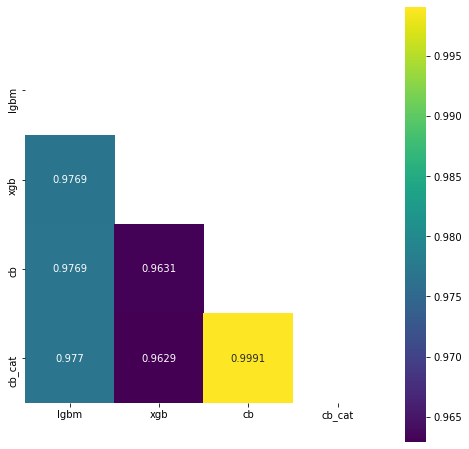

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_test_4, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Наблюдается высокая корреляция между рассматриваемыми несколькими моделями, что свидетельствует о схожей предсказательной силе.

Корреляция между моделями на тестовой выборке выше, чем на обучающей выборке.

## Задание 4
Выполнить задание 2 для трех моделей.

In [51]:
scores_amean = scores_3.mean(axis=1)
auc_amean = roc_auc_score(target, scores_amean)
print(f"AMean Score = {round(auc_amean, 5)}")

scores_gmean = gmean(scores_3, axis=1)
auc_gmean = roc_auc_score(target, scores_gmean)
print(f"GMean Score = {round(auc_gmean, 5)}")

scores_rankdata = scores_3.rank().mean(axis=1)
auc_rankdata = roc_auc_score(target, scores_rankdata)
print(f"Rankdata Score = {round(auc_rankdata, 5)}")

scores_gmean_rankdata = gmean(scores_3.rank(), axis=1)
auc_gmean_rankdata = roc_auc_score(target, scores_gmean_rankdata)
print(f"GMean Rankdata Score = {round(auc_gmean_rankdata, 5)}")

AMean Score = 0.72642
GMean Score = 0.72644
Rankdata Score = 0.72638
GMean Rankdata Score = 0.72637


In [52]:
scores_amean = scores_4.mean(axis=1)
auc_amean = roc_auc_score(target, scores_amean)
print(f"AMean Score = {round(auc_amean, 5)}")

scores_gmean = gmean(scores_4, axis=1)
auc_gmean = roc_auc_score(target, scores_gmean)
print(f"GMean Score = {round(auc_gmean, 5)}")

scores_rankdata = scores_4.rank().mean(axis=1)
auc_rankdata = roc_auc_score(target, scores_rankdata)
print(f"Rankdata Score = {round(auc_rankdata, 5)}")

scores_gmean_rankdata = gmean(scores_4.rank(), axis=1)
auc_gmean_rankdata = roc_auc_score(target, scores_gmean_rankdata)
print(f"GMean Rankdata Score = {round(auc_gmean_rankdata, 5)}")

AMean Score = 0.72644
GMean Score = 0.72646
Rankdata Score = 0.72629
GMean Rankdata Score = 0.72635


**Вывод**
* Качество на одиночных моделях составляет: LightGBM - 0.72286, XGBoost - 0.72668, Catboost - 0.724, Catboost с категориальными признаками - 0.72417.
* Качество усредненных прогнозов по **трем моделям** AMean - 0.72642, GMean - 0.72644, Rankdata - 0.72638, GMean Rankdata - 0.72637
* Усредненные прогнозы по трем моделям имеют незначительные различия качества метрики. 
* Качество одиночной модели XGBoost немного выше качества метрики усредненных прогнозов по трем моделям. 
* Качество усредненных прогнозов по трем моделям выше качества усредненных прогнозов по двум моделям.

* Качество усредненных прогнозов по **четырем моделям** AMean - 0.72644, GMean - 0.72646, Rankdata - 0.72629, GMean Rankdata - 0.72635. Арифметическое среднее и геометрическое среднее по четырем моделям выше, чем по трем моделям, а средние Rankdata - ниже.

## Задание 5. (опция)
Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.¶

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
def lr_cross_validation(model, X, y, cv):
    """
    Кросс-валидация для логистической регрессии.

    """
      
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    X = X.fillna(-1)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
 
        model.fit(X=x_train, y=y_train)
    
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
               
            
    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

### Логистическая регрессия на объединенных OOF-прогнозах 3-х моделей

In [55]:
train_oof_preds = pd.DataFrame(np.vstack((lgbm_oof_preds, xgb_oof_preds, cb_oof_preds, cb_cat_oof_preds)).T,
                                columns=['lgbm', 'xgb', 'cb', 'cb_cat'])

In [56]:
train_oof_preds.head()

,lgbm,xgb,cb,cb_cat
0,0.019668,0.018412,0.027537,0.026070
1,0.085944,0.086530,0.085758,0.085688
2,0.056040,0.057675,0.058633,0.062634
3,0.192507,0.160854,0.204327,0.206858
4,0.082735,0.082997,0.082617,0.082579


In [59]:
train_oof_preds[['lgbm', 'xgb', 'cb']].head()

,lgbm,xgb,cb
0,0.019668,0.018412,0.027537
1,0.085944,0.086530,0.085758
2,0.056040,0.057675,0.058633
3,0.192507,0.160854,0.204327
4,0.082735,0.082997,0.082617


In [60]:
lr_clf = LogisticRegression(random_state=seed, solver="liblinear")

lr_estimators, lr_oof_preds = lr_cross_validation(model=lr_clf,
                                                 X=train_oof_preds[['lgbm', 'xgb', 'cb']],
                                                 y=target,
                                                 cv=cv
                                                 )

Sun Oct 31 20:48:08 2021, Cross-Validation, 110093 rows, 3 cols
Fold 1, Valid score = 0.72314
Fold 2, Valid score = 0.7281
Fold 3, Valid score = 0.73396
Fold 4, Valid score = 0.72556
Fold 5, Valid score = 0.72903
Score by each fold: [0.72314, 0.7281, 0.73396, 0.72556, 0.72903]


In [61]:
lr_oof_score = roc_auc_score(target, lr_oof_preds)
print(f"OOF-score = {round(lr_oof_score, 5)}")

OOF-score = 0.72678


### Логистическая регрессия на объединенных OOF-прогнозах 4-х моделей

In [62]:
lr_clf = LogisticRegression(random_state=seed, solver="liblinear")

lr_estimators, lr_oof_preds = lr_cross_validation(model=lr_clf,
                                                 X=train_oof_preds,
                                                 y=target,
                                                 cv=cv
                                                 )

Sun Oct 31 20:48:16 2021, Cross-Validation, 110093 rows, 4 cols
Fold 1, Valid score = 0.72312
Fold 2, Valid score = 0.72873
Fold 3, Valid score = 0.73367
Fold 4, Valid score = 0.72537
Fold 5, Valid score = 0.7285
Score by each fold: [0.72312, 0.72873, 0.73367, 0.72537, 0.7285]


In [63]:
lr_oof_score = roc_auc_score(target, lr_oof_preds)
print(f"OOF-score = {round(lr_oof_score, 5)}")
# OOF-score = 0.72678 по трем моделям
# OOF-score = 0.72696 по четырем моделям

OOF-score = 0.72696


**Вывод**
* Качество на одиночных моделях составляет: LightGBM - 0.72286, XGBoost - 0.72668, Catboost - 0.724, Catboost с категориальными признаками - 0.72417.
* Качество усредненных прогнозов по трем моделям AMean - 0.72642, GMean - 0.72644, Rankdata - 0.72638, GMean Rankdata - 0.72637
* Качество усредненных прогнозов по четырем моделям AMean - 0.72644, GMean - 0.72646, Rankdata - 0.72629, GMean Rankdata - 0.72635.
* Качество Логистической регрессии немного выше, чем качество одиночных и усредненных прогнозов:
    * построенной на трех моделях - 0.72678
    * построенной на трех моделях - 0.72696